<a href="https://colab.research.google.com/github/ErfanRasti/MachineLearningProjects/blob/main/NeuralNetworks/CIFAR10Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classfiying CIFAR10 dataset using a deep neural network


## Defining functions


## Importing the libraries


In [1]:
from keras.utils import to_categorical
from keras.datasets import cifar10
from tensorflow import keras
from keras import layers
import tensorflow as tf
import pathlib
import os

import matplotlib.pyplot as plt

MODELS_DIR = pathlib.Path('./models/CIFAR10Classification')
print(tf.config.list_physical_devices('GPU'))


2023-01-09 12:23:50.820404: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-09 12:23:53.059197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-09 12:23:53.080241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-09 12:23:53.080769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
def plot_history(history):
    """Plot training and validation loss and accuracy metrics."""

    fig = plt.figure(figsize=(10, 10))
    fig.canvas.manager.set_window_title(
        'Training and validation loss and accuracy')

    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b',
             label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo',
             label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'b',
             label='Validation accracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.show()


def model_evaluation(model, test_images, test_labels, label_dict):
    """Evaluate model performance on test data."""

    (test_loss,
     test_acc,
     test_AUC,
     test_precision,
     test_recall) = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    print('Test AUC:', test_AUC)
    print('Test precision:', test_precision)
    print('Test recall:', test_recall)

    predictions = model.predict(test_images)

    confussion_matrix = tf.math.confusion_matrix(
        labels=test_labels.argmax(axis=1),
        predictions=predictions.argmax(axis=1))

    print('Confussion matrix:')
    print(confussion_matrix)

    plt.figure(figsize=(10, 10))
    plt.imshow(confussion_matrix, cmap=plt.cm.Blues)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(labels=list(label_dict.values()), ticks=list(label_dict.keys()))
    plt.yticks(labels=list(label_dict.values()), ticks=list(label_dict.keys()))
    plt.grid(False)
    plt.show()


## Importing the dataset


In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert X_test.shape == (10000, 32, 32, 3)
assert y_test.shape == (10000, 1)


In [4]:
label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}


## Show some images


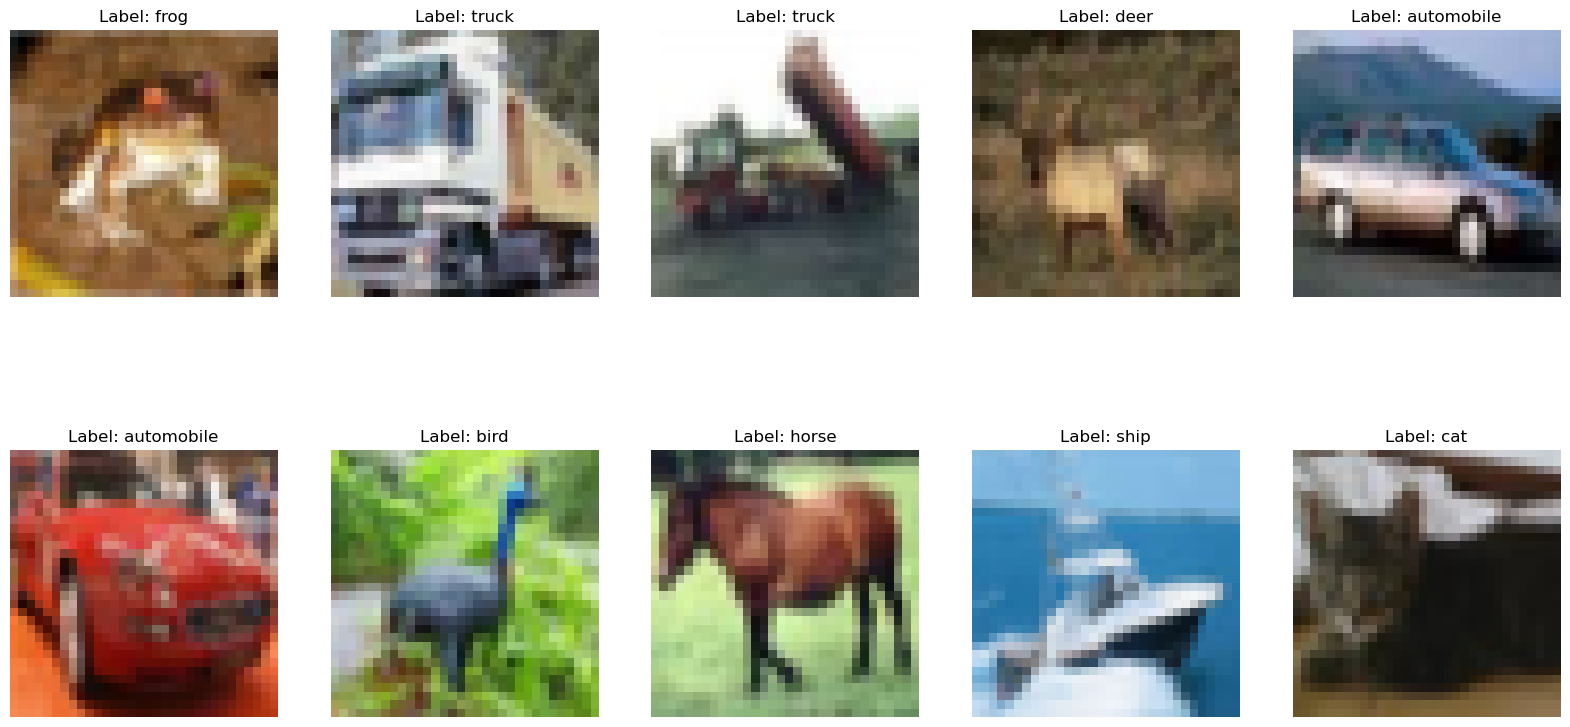

In [5]:
plt.figure(figsize=(20, 10))

for i in range(10):
    subplt = plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title('Label: {}'.format(label_dict[y_train[i][0]]))


## Preprocessing the data


In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [7]:
X_val = X_train[-20000:]
y_val = y_train[-20000:]

X_train = X_train[:-20000]
y_train = y_train[:-20000]

X_train.shape, X_val.shape, X_test.shape


((30000, 32, 32, 3), (20000, 32, 32, 3), (10000, 32, 32, 3))

## Designing a simple multilayer perceptron model


In [ ]:
def get_model():
    "Returns a compiled model."
    inputs = keras.Input(shape=(32, 32, 3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='CIFAR10_MLP_Classification')

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model


In [ ]:
model = get_model()
model.summary()


Model: "CIFAR10_MLP_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 10) 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_32.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)


Epoch 1/50
938/938 [==============================] - 10s 8ms/step - loss: 2.0660 - accuracy: 0.2402 - auc: 0.7191 - precision: 0.4573 - recall: 0.0328 - val_loss: 1.9097 - val_accuracy: 0.2884 - val_auc: 0.7748 - val_precision: 0.5158 - val_recall: 0.0343
Epoch 2/50
938/938 [==============================] - 7s 7ms/step - loss: 1.9156 - accuracy: 0.2922 - auc: 0.7687 - precision: 0.5249 - recall: 0.0632 - val_loss: 1.8611 - val_accuracy: 0.3276 - val_auc: 0.7878 - val_precision: 0.6588 - val_recall: 0.0292
Epoch 3/50
938/938 [==============================] - 7s 7ms/step - loss: 1.8713 - accuracy: 0.3160 - auc: 0.7825 - precision: 0.5439 - recall: 0.0812 - val_loss: 1.9337 - val_accuracy: 0.3047 - val_auc: 0.7609 - val_precision: 0.6379 - val_recall: 0.0192
Epoch 4/50
938/938 [==============================] - 7s 8ms/step - loss: 1.8551 - accuracy: 0.3234 - auc: 0.7873 - precision: 0.5510 - recall: 0.0862 - val_loss: 1.7979 - val_accuracy: 0.3498 - val_auc: 0.8025 - val_precision: 0.6

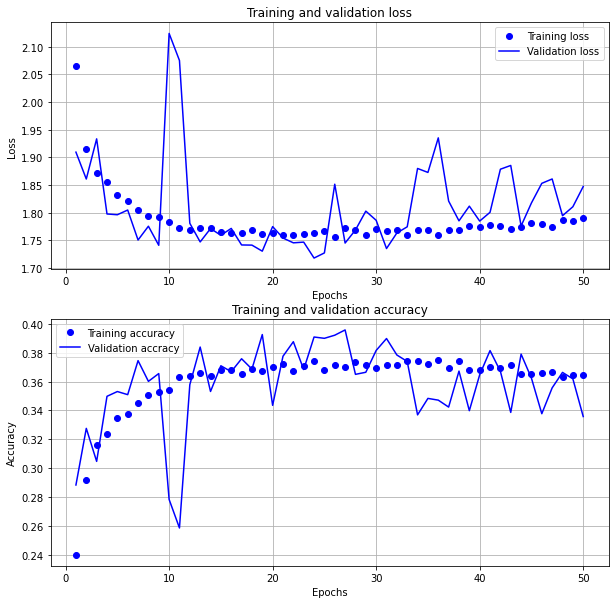

In [ ]:
plot_history(history)


## Evaluating the model


313/313 [==============================] - 2s 4ms/step - loss: 1.7036 - accuracy: 0.3987 - auc: 0.8293 - precision: 0.6601 - recall: 0.1165
Test accuracy: 0.3986999988555908
Test loss: 1.7036269903182983
Test AUC: 0.8293384909629822
Test precision: 0.6600566506385803
Test recall: 0.11649999767541885
313/313 [==============================] - 1s 2ms/step
Confussion matrix:
tf.Tensor(
[[468  44  22  71   6   4  16  32 270  67]
 [ 44 491   7  57  12   9  14  20 157 189]
 [156  36 134 218 187  54  59  69  62  25]
 [ 59  35  42 424  64  96  95  35 110  40]
 [ 76  14  75 188 354  18  94 101  57  23]
 [ 42  17  57 291  83 197  69  63 161  20]
 [ 13  38  36 255 186  41 353  26  33  19]
 [ 77  21  41 128  92  45  18 429  69  80]
 [ 94  66   3  45   2   5   6   7 701  71]
 [ 42 172   4  77   8   7  25  46 183 436]], shape=(10, 10), dtype=int32)


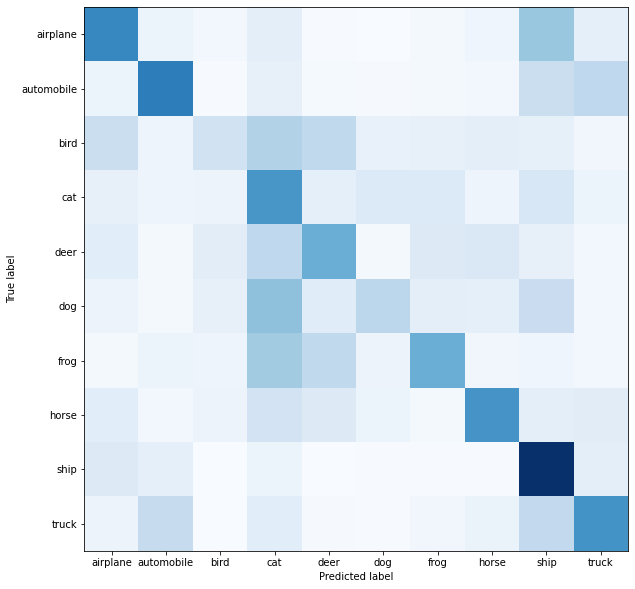

In [ ]:
model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_32.keras'))

model_evaluation(model, X_test, y_test, label_dict)


## Setting different batch sizes

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 2.0971 - accuracy: 0.2371 - auc: 0.7113 - precision: 0.4613 - recall: 0.0282 - val_loss: 2.0018 - val_accuracy: 0.2693 - val_auc: 0.7461 - val_precision: 0.3923 - val_recall: 0.0833
Epoch 2/50
469/469 [==============================] - 4s 7ms/step - loss: 1.9059 - accuracy: 0.3043 - auc: 0.7712 - precision: 0.5394 - recall: 0.0671 - val_loss: 1.8491 - val_accuracy: 0.3270 - val_auc: 0.7872 - val_precision: 0.5900 - val_recall: 0.0764
Epoch 3/50
469/469 [==============================] - 4s 7ms/step - loss: 1.8547 - accuracy: 0.3231 - auc: 0.7868 - precision: 0.5577 - recall: 0.0852 - val_loss: 1.8238 - val_accuracy: 0.3382 - val_auc: 0.7983 - val_precision: 0.6303 - val_recall: 0.0465
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 1.8133 - accuracy: 0.3402 - auc: 0.7981 - precision: 0.5721 - recall: 0.0994 - val_loss: 1.7769 - val_accuracy: 0.3552 - val_auc: 0.8129 - val_precision: 0.61

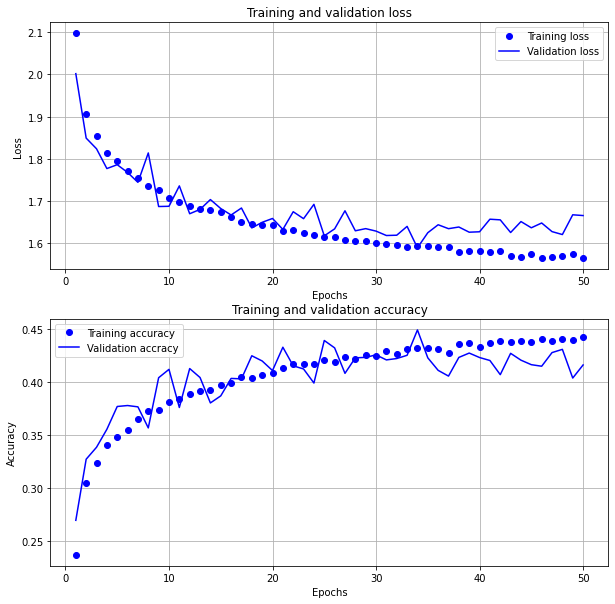

313/313 [==============================] - 2s 4ms/step - loss: 1.5668 - accuracy: 0.4482 - auc: 0.8587 - precision: 0.7066 - recall: 0.1633
Test accuracy: 0.448199987411499
Test loss: 1.5667675733566284
Test AUC: 0.8587372899055481
Test precision: 0.7066205143928528
Test recall: 0.16329999268054962
313/313 [==============================] - 1s 2ms/step
Confussion matrix:
tf.Tensor(
[[331  49  88  98  30  14  27  74 183 106]
 [ 12 576  10  72  16  16  22  35  40 201]
 [ 48  24 264 158 169  78 119 103  15  22]
 [  6  20  81 426  61 155 112  84  25  30]
 [ 23   8 125 128 374  29 117 153  21  22]
 [  4  14  86 302  61 290  65 108  41  29]
 [  1  10  51 185 134  38 514  44  10  13]
 [ 11  21  32 111  77  69  30 559  14  76]
 [ 44 104  21  63  25  12  13  15 582 121]
 [  8 174  11  89  11  16  28  48  49 566]], shape=(10, 10), dtype=int32)


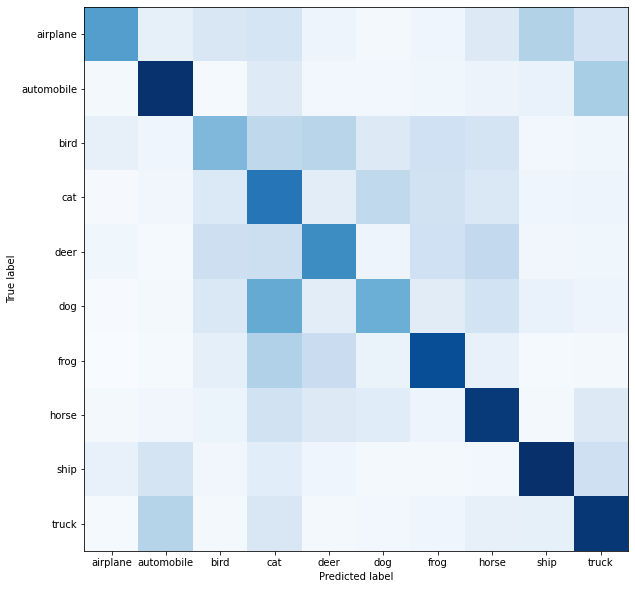

In [ ]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_64.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)

plot_history(history)

model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_64.keras'))

model_evaluation(model, X_test, y_test, label_dict)


Epoch 1/50
127/127 [==============================] - 3s 16ms/step - loss: 2.2831 - accuracy: 0.1984 - auc: 0.6661 - precision: 0.2689 - recall: 0.0119 - val_loss: 2.2057 - val_accuracy: 0.2095 - val_auc: 0.6873 - val_precision: 0.2801 - val_recall: 0.0391
Epoch 2/50
127/127 [==============================] - 1s 11ms/step - loss: 1.9785 - accuracy: 0.2812 - auc: 0.7484 - precision: 0.4972 - recall: 0.0414 - val_loss: 2.0615 - val_accuracy: 0.2491 - val_auc: 0.7170 - val_precision: 0.4550 - val_recall: 0.0397
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 1.9021 - accuracy: 0.3109 - auc: 0.7717 - precision: 0.5555 - recall: 0.0665 - val_loss: 1.8437 - val_accuracy: 0.3300 - val_auc: 0.7889 - val_precision: 0.5908 - val_recall: 0.0891
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: 1.8501 - accuracy: 0.3287 - auc: 0.7890 - precision: 0.5500 - recall: 0.0824 - val_loss: 2.1100 - val_accuracy: 0.2629 - val_auc: 0.7413 - val_precision: 0.

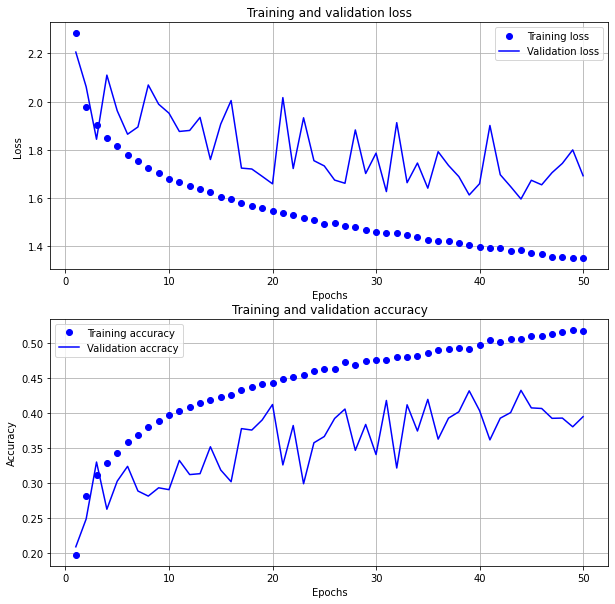

313/313 [==============================] - 2s 4ms/step - loss: 1.5911 - accuracy: 0.4324 - auc: 0.8526 - precision: 0.6375 - recall: 0.1848
Test accuracy: 0.4323999881744385
Test loss: 1.5910749435424805
Test AUC: 0.8525829315185547
Test precision: 0.6374611854553223
Test recall: 0.18479999899864197
313/313 [==============================] - 1s 2ms/step
Confussion matrix:
tf.Tensor(
[[449  74  67  29 115   4  22  19 117 104]
 [ 26 593  16  30  33  11  22  24  44 201]
 [ 71  32 205  97 347  41 105  47  21  34]
 [ 38  39  64 309 174  74 142  53  43  64]
 [ 39  22  72  46 592  23 106  56  18  26]
 [ 16  36  59 256 158 193 106  89  40  47]
 [ 13  24  38 100 222  26 526  20  10  21]
 [ 42  22  37  68 237  30  49 398  18  99]
 [128  99  25  23  49   4  11  13 501 147]
 [ 32 195  13  36  43   7  48  24  44 558]], shape=(10, 10), dtype=int32)


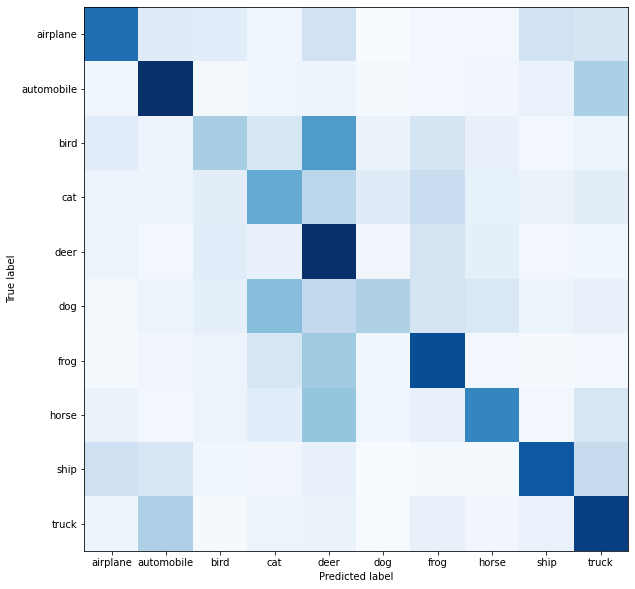

In [ ]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_128.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=238,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)

plot_history(history)

model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_128.keras'))

model_evaluation(model, X_test, y_test, label_dict)


- The best batch size is 64. When we increase the batch size, the accuracy increases. But when we increase the batch size more than 64, the accuracy decreases.
- The model with batch size 64 is better than the model with batch size 32. Because it has larger samples per step and it has more reliable results.
- When the batch size is too large model is not able to learn from the data in the same epochs. We should increase the number of epochs to prevent this problem. But this is not a good solution because it increases the training time.
- If the number epochs is the same, the model with the larger batch size will take less time to train. Because the number of steps per epoch is smaller.


## Setting different activation functions

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 2.0355 - accuracy: 0.2534 - auc: 0.7242 - precision: 0.5202 - recall: 0.0304 - val_loss: 1.8678 - val_accuracy: 0.3211 - val_auc: 0.7819 - val_precision: 0.6304 - val_recall: 0.0371
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 1.8439 - accuracy: 0.3313 - auc: 0.7898 - precision: 0.5600 - recall: 0.0796 - val_loss: 1.7388 - val_accuracy: 0.3801 - val_auc: 0.8186 - val_precision: 0.6389 - val_recall: 0.0825
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 1.7589 - accuracy: 0.3654 - auc: 0.8122 - precision: 0.6046 - recall: 0.1125 - val_loss: 1.7237 - val_accuracy: 0.3758 - val_auc: 0.8222 - val_precision: 0.5627 - val_recall: 0.1591
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 1.7087 - accuracy: 0.3832 - auc: 0.8245 - precision: 0.6018 - recall: 0.1381 - val_loss: 1.8481 - val_accuracy: 0.3322 - val_auc: 0.7960 - val_precision: 0.51

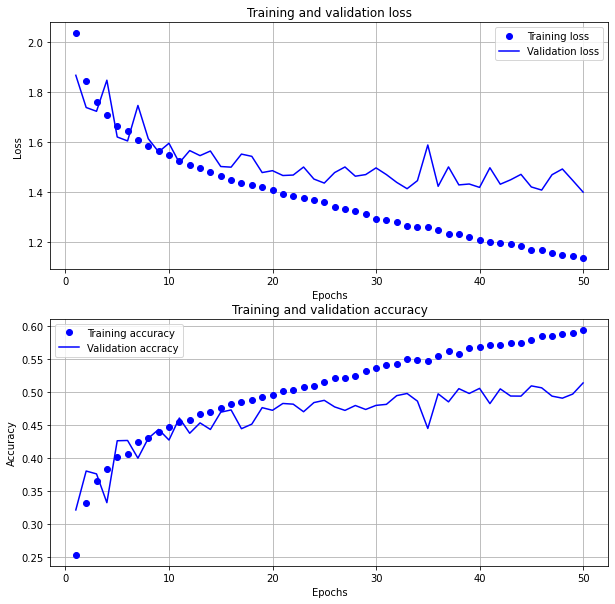

313/313 [==============================] - 2s 4ms/step - loss: 1.3749 - accuracy: 0.5158 - auc: 0.8928 - precision: 0.6722 - recall: 0.3430
Test accuracy: 0.5157999992370605
Test loss: 1.3748666048049927
Test AUC: 0.8927780389785767
Test precision: 0.672153651714325
Test recall: 0.34299999475479126
313/313 [==============================] - 1s 2ms/step
Confussion matrix:
tf.Tensor(
[[586  22  55  45  38  10  26  19 145  54]
 [ 40 540  18  50  10  14  11  13  77 227]
 [ 80  15 332 144 189  60  91  45  22  22]
 [ 36  15  62 468  64 143  97  39  28  48]
 [ 47   5  92 110 491  36 107  66  23  23]
 [ 28   8  89 303  72 339  68  45  21  27]
 [  7  19  62 127 130  37 572  12   8  26]
 [ 29   5  44 111 103  75  21 533  24  55]
 [115  51  12  38  17   7  12  11 675  62]
 [ 45 106  10  52   8  15  19  33  90 622]], shape=(10, 10), dtype=int32)


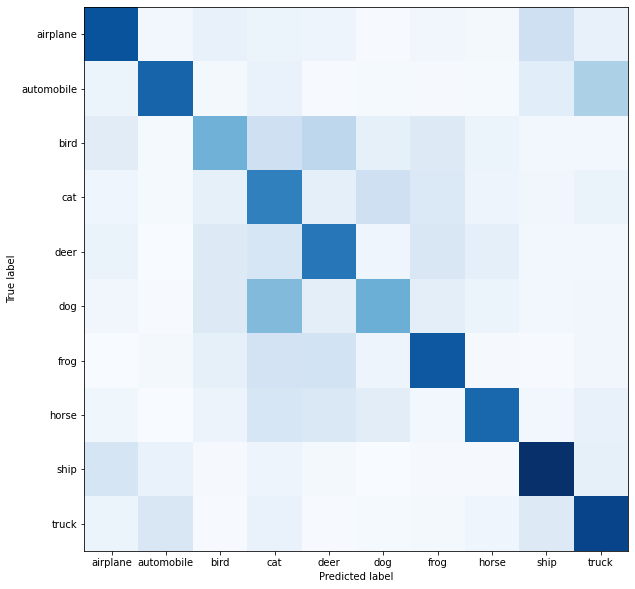

In [ ]:
def get_model():
    "Returns a compiled model."
    inputs = keras.Input(shape=(32, 32, 3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='sigmoid')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(512, activation='sigmoid')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='CIFAR10_MLP_Classification')

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_64_act_sigmoid.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)

plot_history(history)

model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_64_act_sigmoid.keras'))

model_evaluation(model, X_test, y_test, label_dict)


Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 2.2624 - accuracy: 0.1982 - auc: 0.6619 - precision: 0.3068 - recall: 0.0220 - val_loss: 2.0590 - val_accuracy: 0.2469 - val_auc: 0.7244 - val_precision: 0.5171 - val_recall: 0.0234
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 1.9941 - accuracy: 0.2792 - auc: 0.7490 - precision: 0.4457 - recall: 0.0588 - val_loss: 2.0004 - val_accuracy: 0.2756 - val_auc: 0.7506 - val_precision: 0.4950 - val_recall: 0.0893
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 1.9018 - accuracy: 0.3138 - auc: 0.7762 - precision: 0.5035 - recall: 0.0905 - val_loss: 1.8915 - val_accuracy: 0.3315 - val_auc: 0.7752 - val_precision: 0.5901 - val_recall: 0.0809
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 1.8540 - accuracy: 0.3309 - auc: 0.7900 - precision: 0.5113 - recall: 0.1065 - val_loss: 1.7962 - val_accuracy: 0.3602 - val_auc: 0.8016 - val_precision: 0.60

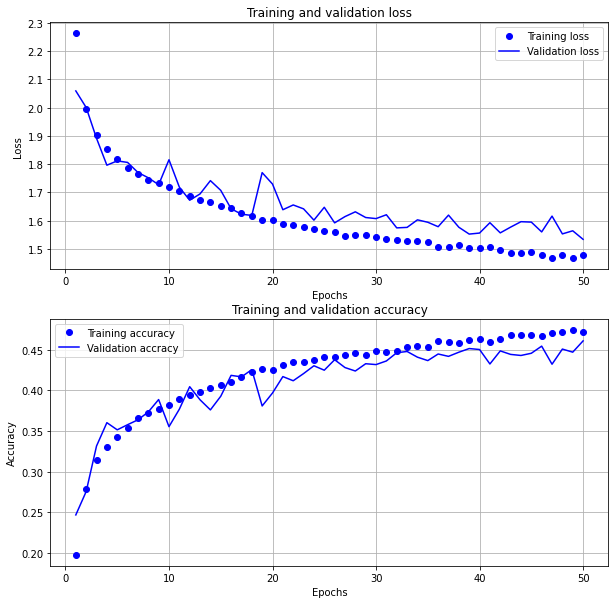

313/313 [==============================] - 2s 4ms/step - loss: 1.5022 - accuracy: 0.4675 - auc: 0.8700 - precision: 0.6290 - recall: 0.3014
Test accuracy: 0.4675000011920929
Test loss: 1.502211570739746
Test AUC: 0.869961678981781
Test precision: 0.6289649605751038
Test recall: 0.30140000581741333
313/313 [==============================] - 1s 2ms/step
Confussion matrix:
tf.Tensor(
[[530  65  21  44  21  14  33  45 203  24]
 [ 49 701   3  17   3  26  25  25  64  87]
 [ 93  53 145 132 141 110 169  97  45  15]
 [ 36  42  26 329  44 176 182  74  52  39]
 [ 69  34  41  78 369  52 182 132  32  11]
 [ 26  32  29 220  61 325 141  96  51  19]
 [ 18  28  21  94  99  36 630  33  25  16]
 [ 63  41  14  84  63  71  47 554  22  41]
 [107  86   3  21  12  16  15  19 673  48]
 [ 71 287   1  43   4  22  29  41  83 419]], shape=(10, 10), dtype=int32)


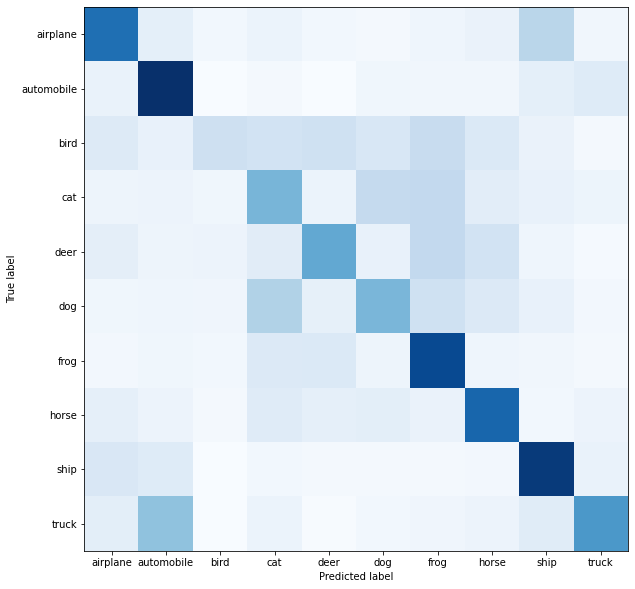

In [ ]:
def get_model():
    "Returns a compiled model."
    inputs = keras.Input(shape=(32, 32, 3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='tanh')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(512, activation='tanh')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='CIFAR10_MLP_Classification')

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_64_act_tanh.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)

plot_history(history)

model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_64_act_tanh.keras'))

model_evaluation(model, X_test, y_test, label_dict)


The best activation function in this case is sigmoid. It has more accuracy than tanh and tanh has more accuracy than relu.

## Setting different loss function

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 0.0848 - accuracy: 0.2427 - auc: 0.7050 - precision: 0.4980 - recall: 0.0296 - val_loss: 0.0802 - val_accuracy: 0.3160 - val_auc: 0.7659 - val_precision: 0.5503 - val_recall: 0.0809
Epoch 2/50
469/469 [==============================] - 4s 7ms/step - loss: 0.0797 - accuracy: 0.3192 - auc: 0.7736 - precision: 0.5527 - recall: 0.0760 - val_loss: 0.0798 - val_accuracy: 0.3214 - val_auc: 0.7626 - val_precision: 0.5693 - val_recall: 0.1082
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0772 - accuracy: 0.3530 - auc: 0.7943 - precision: 0.6049 - recall: 0.1052 - val_loss: 0.0780 - val_accuracy: 0.3454 - val_auc: 0.7859 - val_precision: 0.6175 - val_recall: 0.0712
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0758 - accuracy: 0.3702 - auc: 0.8073 - precision: 0.6116 - recall: 0.1266 - val_loss: 0.0769 - val_accuracy: 0.3571 - val_auc: 0.8034 - val_precision: 0.56

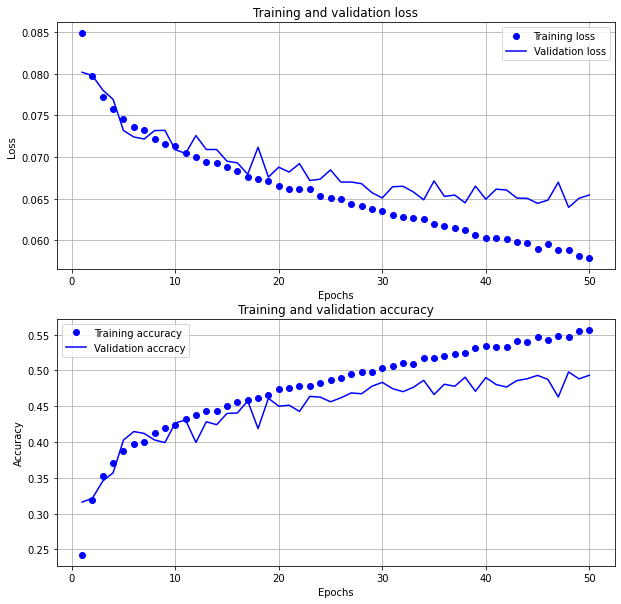

313/313 [==============================] - 2s 4ms/step - loss: 0.0636 - accuracy: 0.5034 - auc: 0.8824 - precision: 0.6889 - recall: 0.3120
Test accuracy: 0.5034000277519226
Test loss: 0.0635635256767273
Test AUC: 0.8823827505111694
Test precision: 0.6888937950134277
Test recall: 0.31200000643730164
313/313 [==============================] - 1s 2ms/step
Confussion matrix:
tf.Tensor(
[[613  34  97  12  31  13  14  31 118  37]
 [ 66 631  32  13  10  16  10  32  58 132]
 [ 93  26 433  40 149  71  67  74  26  21]
 [ 52  26 132 235  47 246  92  65  41  64]
 [ 70  13 168  40 482  56  63  72  22  14]
 [ 35  24 135 121  63 414  61  89  29  29]
 [ 17  24 105  52 144  73 501  33  21  30]
 [ 52  25  87  35  72  71  23 565  22  48]
 [156  60  27  10  21  25   7  22 628  44]
 [ 64 181  22  23  18  31  13  38  78 532]], shape=(10, 10), dtype=int32)


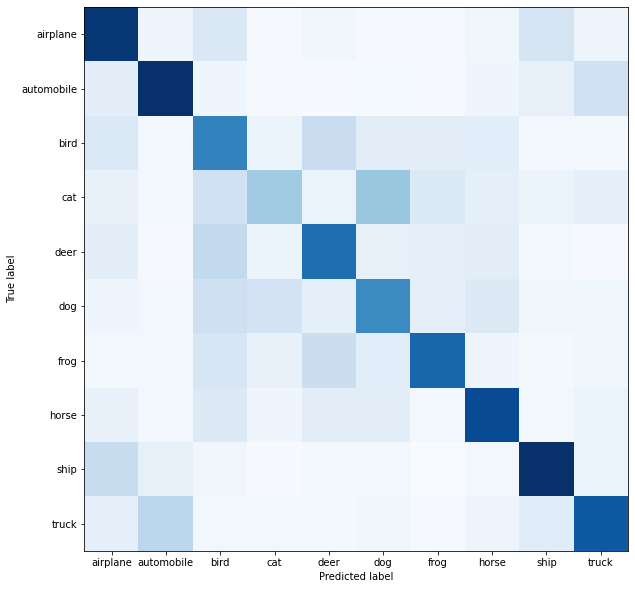

In [31]:
def get_model():
    "Returns a compiled model."
    inputs = keras.Input(shape=(32, 32, 3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='sigmoid')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(512, activation='sigmoid')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='CIFAR10_MLP_Classification')

    model.compile(loss='mse',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_64_act_sigmoid_loss_mse.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)

plot_history(history)

model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_64_act_sigmoid_loss_mse.keras'))

model_evaluation(model, X_test, y_test, label_dict)


The categorical cross entropy has better accuracy. RMSE is not a good loss function for classification problems.  It is usually used for regression. Categorical cross entropy works based on the information theory and minimum bits which is needed for sending a messages.

## Modern DNN Architecture Using Residual Convolutional Neural Networks

In [17]:
def get_model():
    "Returns a compiled model."

    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.05),
        ]
    )

    inputs = keras.Input(shape=(32, 32, 3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1. / 255)(x)

    x = layers.Conv2D(32, kernel_size=3, padding='same')(x)
    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    residual = x
    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)

    residual = layers.Conv2D(128,
                             kernel_size=1,
                             strides=(1, 1),
                             use_bias=False)(residual)
    residual = layers.BatchNormalization()(residual)
    x = layers.Add()([residual, x])

    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(1, 1), strides=(2, 2))(x)

    residual = x
    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.Conv2D(512, kernel_size=3, padding='same')(x)
    residual = layers.Conv2D(512,
                             kernel_size=1,
                             strides=(1, 1),
                             use_bias=False)(residual)
    residual = layers.BatchNormalization()(residual)
    x = layers.Add()([residual, x])

    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='CIFAR10_ResidualCNN_Classification')

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model


model = get_model()
model.summary()


Model: "CIFAR10_ResidualCNN_Classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_5 (Sequential)      (None, 32, 32, 3)    0           ['input_6[0][0]']                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 32, 32, 3)    0           ['sequential_5[0][0]']           
                                                                                                  
 conv2d_52 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_5[0][0]']            
                                                                 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'modern_arch_ResidualCNN.h5'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=120,
                    callbacks=callbacks)


In [ ]:
plot_history(history)

model = keras.models.load_model(
    os.path.join(MODELS_DIR, 'modern_arch_ResidualCNN.h5'))


model_evaluation(model, X_test, y_test, label_dict)